## Loading Data

In [186]:
from pathlib import Path

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 100)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [193]:
!pip install -U scikit-learn
!pip install lightgbm
!pip install catboost
!pip install category_encoders
!pip install optuna

  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=59818751751c24543adef0e0b249ad55686f7831dbdab976001077f8bf42f3c4
  Stored in directory: c:\users\vanga\appdata\local\pip\cache\wheels\0c\09\9e\49e21a6840ef7955b06d47394afef0058f0378c0914e48b8b8
Successfully built pyperclip


In [187]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.1.1.


In [20]:
DATA_PATH = Path.cwd().parent / "data" / "final" / "public"

In [22]:
features_df = pd.read_csv(
    DATA_PATH / "training_set_features.csv", 
    index_col="respondent_id"
)
labels_df = pd.read_csv(
    DATA_PATH / "training_set_labels.csv", 
    index_col="respondent_id"
)

In [23]:
print("features_df.shape", features_df.shape)
features_df.head()

features_df.shape (26707, 35)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [24]:
features_df.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

In [25]:
print("labels_df.shape", labels_df.shape)
labels_df.head()

labels_df.shape (26707, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [26]:
np.testing.assert_array_equal(features_df.index.values, labels_df.index.values)

## Exploring the data

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

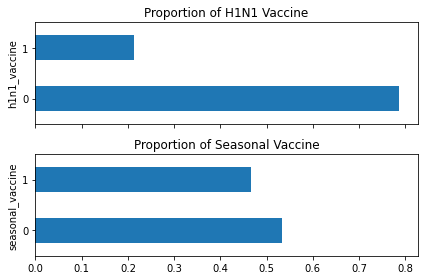

In [28]:
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = labels_df.shape[0]

(labels_df['h1n1_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

(labels_df['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()

In [ ]:
# It looks like roughy half of people received the seasonal flu vaccine, but only about 20% of people received the H1N1 flu vaccine. In terms of class balance, we say that the seasonal flu vaccine target has balanced classes, but the H1N1 flu vaccine target has moderately imbalanced classes. Hence, we will use class weights method only for H1N1 vaccine target

In [31]:
np.corrcoef(labels_df['h1n1_vaccine'], labels_df['seasonal_vaccine'])[0,1]

0.3771426530614447

In [ ]:
# Combine features and labels into one dataframe.

In [32]:
joined_df = features_df.join(labels_df)
print(joined_df.shape)
joined_df.head()

(26707, 37)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [ ]:
# Exploring relationships between each feature and target

In [33]:
counts = (joined_df[['h1n1_concern', 'h1n1_vaccine']]
              .groupby(['h1n1_concern', 'h1n1_vaccine'])
              .size()
              .unstack('h1n1_vaccine')
         )
counts

h1n1_vaccine,0,1
h1n1_concern,,
0.0,2849,447
1.0,6756,1397
2.0,8102,2473
3.0,3250,1341


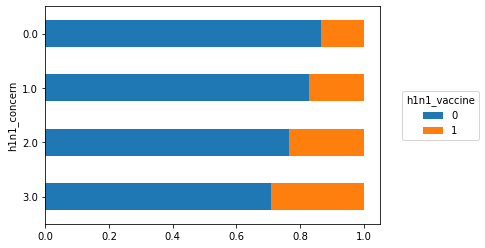

In [51]:
h1n1_concern_counts = counts.sum(axis='columns')
props = counts.div(h1n1_concern_counts, axis='index')
ax = props.plot.barh(stacked=True)
ax.invert_yaxis()
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
)

In [ ]:
# % of number of people who got vaccinated in the four h1n1_concern categories are 0-13.56%, 1-17.13%, 2-23.39%, 3-29.21%. Hence, greater the level of concern on h1n1, greater the vaccination rate. Hence, h1n1_concern will be a useful feature when we get to modeling.

In [52]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (joined_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

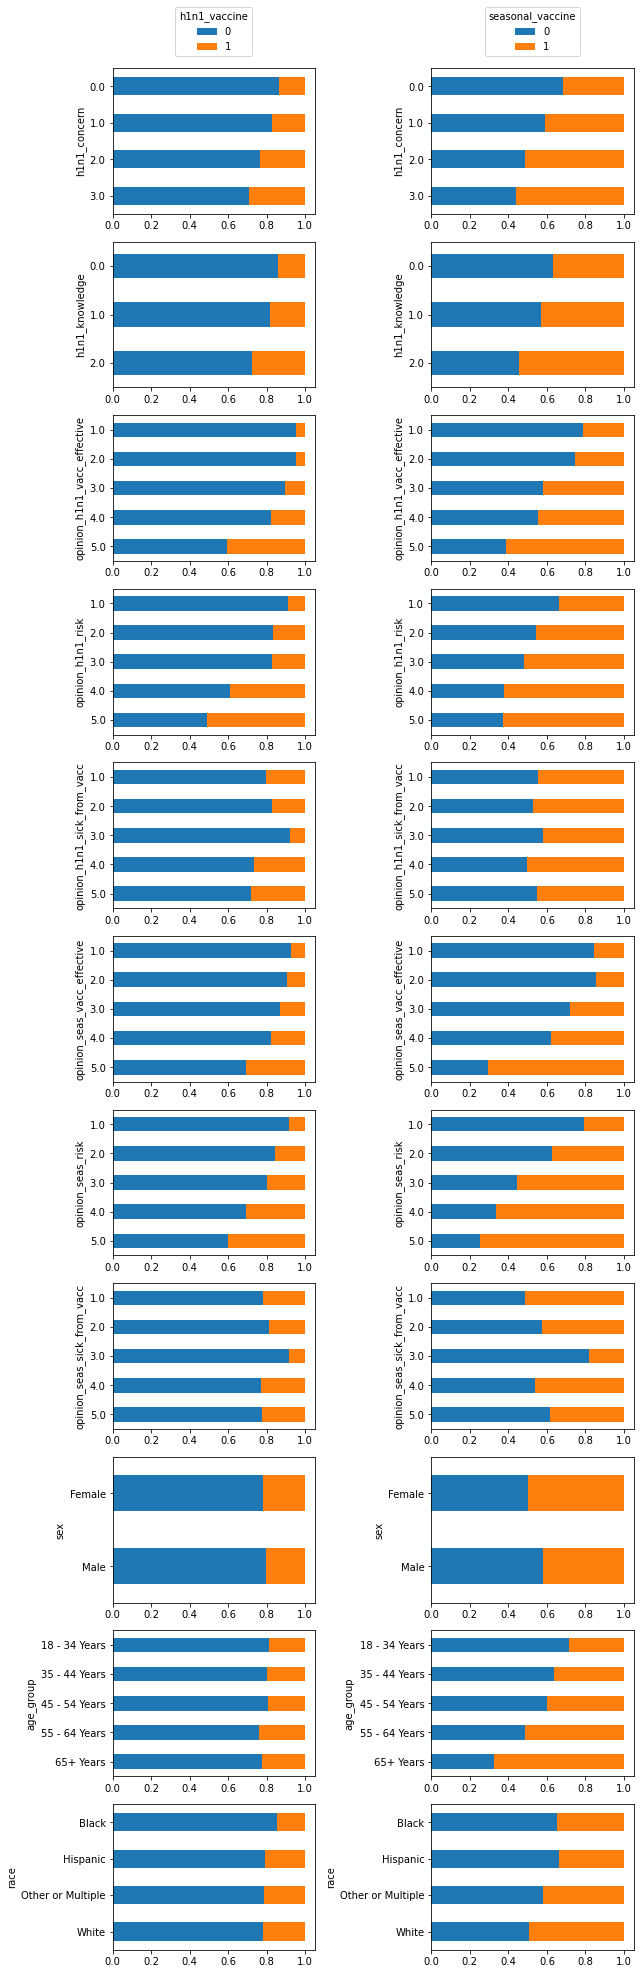

In [53]:
cols_to_plot = [
    'h1n1_concern',
    'h1n1_knowledge',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
    'sex',
    'age_group',
    'race',
]

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', joined_df, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', joined_df, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

##It looks like the knowledge and opinion questions have pretty strong signal for both target variables.bThe demographic features have stronger correlation with seasonal_vaccine, but much less so far h1n1_vaccine. In particular, we interestingly see a strong correlation with age_group with the seasonal_vaccine but not with h1n1_vaccine. It appears that with seasonal flu, people act appropriately according to the fact that people more impacted and have higher risk of flu-related complications with age. It turns out though that H1N1 flu has an interesting relationship with age: even though older people have higher risk of complications, they were less likely to get infected! While we know anything about causality from this analysis, it seems like the risk factors ended up being reflected in the vaccination rates.

# Feature Preprocessing

In [194]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
from catboost import Pool, cv

from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate

from sklearn.metrics import roc_curve, roc_auc_score

from category_encoders import OrdinalEncoder as oe

import optuna

RANDOM_SEED = 6    # Set a random seed for reproducibility!

In [68]:
train = pd.read_csv(
    DATA_PATH / "training_set_features.csv", 
    index_col="respondent_id"
)
test = pd.read_csv(
    DATA_PATH / "test_set_features.csv", 
    index_col="respondent_id"
)
labels = pd.read_csv(
    DATA_PATH / "training_set_labels.csv", 
    index_col="respondent_id"
)

In [197]:
labels_h1n1_vaccine = labels['h1n1_vaccine']
labels_seasonal_vaccine = labels['seasonal_vaccine']

In [ ]:
# Dividing Data into numerical, categorical and ordinal datatypes 

In [70]:
num_cols = train.select_dtypes('number').columns
cat_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']
ord_cols = ['age_group', 'education',  'income_poverty',
        'employment_status']
assert len(num_cols)+len(cat_cols)+len(ord_cols) == train.shape[1]

In [ ]:
# Converting Ordinal Categorical Variables into Ranking numbers

In [91]:
train['age_group'][train['age_group']=='18 - 34 Years'] = 1
train['age_group'][train['age_group']=='35 - 44 Years'] = 2
train['age_group'][train['age_group']=='45 - 54 Years'] = 3
train['age_group'][train['age_group']=='55 - 64 Years'] = 4
train['age_group'][train['age_group']=='65+ Years'] = 5

test['age_group'][test['age_group']=='18 - 34 Years'] = 1
test['age_group'][test['age_group']=='35 - 44 Years'] = 2
test['age_group'][test['age_group']=='45 - 54 Years'] = 3
test['age_group'][test['age_group']=='55 - 64 Years'] = 4
test['age_group'][test['age_group']=='65+ Years'] = 5

C:\Users\vanga\AppData\Local\Temp/ipykernel_51324/1972991993.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['age_group'][train['age_group']=='18 - 34 Years'] = 1
C:\Users\vanga\AppData\Local\Temp/ipykernel_51324/1972991993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['age_group'][train['age_group']=='35 - 44 Years'] = 2
C:\Users\vanga\AppData\Local\Temp/ipykernel_51324/1972991993.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [99]:
train['age_group']

respondent_id
0        4
1        2
2        1
3        5
4        3
        ..
26702    5
26703    1
26704    4
26705    1
26706    5
Name: age_group, Length: 26707, dtype: object

In [100]:
test['age_group']

respondent_id
26707    2
26708    1
26709    4
26710    5
26711    2
        ..
53410    2
53411    1
53412    1
53413    4
53414    3
Name: age_group, Length: 26708, dtype: object

In [95]:
train['education'][train['education']=='< 12 Years'] = 1
train['education'][train['education']=='12 Years'] = 2
train['education'][train['education']=='Some College'] = 3
train['education'][train['education']=='College Graduate'] = 4

test['education'][test['education']=='< 12 Years'] = 1
test['education'][test['education']=='12 Years'] = 2
test['education'][test['education']=='Some College'] = 3
test['education'][test['education']=='College Graduate'] = 4

C:\Users\vanga\AppData\Local\Temp/ipykernel_51324/2702519352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['education'][train['education']=='< 12 Years'] = 1
C:\Users\vanga\AppData\Local\Temp/ipykernel_51324/2702519352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['education'][train['education']=='12 Years'] = 2
C:\Users\vanga\AppData\Local\Temp/ipykernel_51324/2702519352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [101]:
train['education']

respondent_id
0        1
1        2
2        4
3        2
4        3
        ..
26702    3
26703    4
26704    3
26705    3
26706    3
Name: education, Length: 26707, dtype: object

In [102]:
test['education']

respondent_id
26707      4
26708      2
26709      4
26710      2
26711      2
        ... 
53410    NaN
53411      2
53412      3
53413      3
53414      4
Name: education, Length: 26708, dtype: object

In [103]:
train['income_poverty'][train['income_poverty']=='Below Poverty'] = 1
train['income_poverty'][train['income_poverty']=='<= $75,000, Above Poverty'] = 2
train['income_poverty'][train['income_poverty']=='> $75,000'] = 3

test['income_poverty'][test['income_poverty']=='Below Poverty'] = 1
test['income_poverty'][test['income_poverty']=='<= $75,000, Above Poverty'] = 2
test['income_poverty'][test['income_poverty']=='> $75,000'] = 3

C:\Users\vanga\AppData\Local\Temp/ipykernel_51324/1714987607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['income_poverty'][train['income_poverty']=='Below Poverty'] = 1
C:\Users\vanga\AppData\Local\Temp/ipykernel_51324/1714987607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['income_poverty'][train['income_poverty']=='<= $75,000, Above Poverty'] = 2
C:\Users\vanga\AppData\Local\Temp/ipykernel_51324/1714987607.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [104]:
train['income_poverty']

respondent_id
0          1
1          1
2          2
3          1
4          2
        ... 
26702      2
26703      2
26704    NaN
26705      2
26706      2
Name: income_poverty, Length: 26707, dtype: object

In [105]:
test['income_poverty']

respondent_id
26707      3
26708      1
26709      3
26710      2
26711      2
        ... 
53410    NaN
53411      1
53412      1
53413      2
53414    NaN
Name: income_poverty, Length: 26708, dtype: object

In [106]:
train['employment_status'][train['employment_status']=='Not in Labor Force'] = 1
train['employment_status'][train['employment_status']=='Unemployed'] = 2
train['employment_status'][train['employment_status']=='Employed'] = 3

test['employment_status'][test['employment_status']=='Not in Labor Force'] = 1
test['employment_status'][test['employment_status']=='Unemployed'] = 2
test['employment_status'][test['employment_status']=='Employed'] = 3

C:\Users\vanga\AppData\Local\Temp/ipykernel_51324/1692682778.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['employment_status'][train['employment_status']=='Not in Labor Force'] = 1
C:\Users\vanga\AppData\Local\Temp/ipykernel_51324/1692682778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['employment_status'][train['employment_status']=='Unemployed'] = 2
C:\Users\vanga\AppData\Local\Temp/ipykernel_51324/1692682778.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [107]:
train['employment_status']

respondent_id
0          1
1          3
2          3
3          1
4          3
        ... 
26702      1
26703      3
26704    NaN
26705      3
26706      1
Name: employment_status, Length: 26707, dtype: object

In [108]:
test['employment_status']

respondent_id
26707      3
26708      3
26709      3
26710      1
26711      3
        ... 
53410    NaN
53411      3
53412      1
53413      1
53414      3
Name: employment_status, Length: 26708, dtype: object

In [208]:
train['age_group'] = train['age_group'].astype('float64')
train['education'] = train['education'].astype('float64')
train['income_poverty'] = train['income_poverty'].astype('float64')
train['employment_status'] = train['employment_status'].astype('float64')

test['age_group'] = test['age_group'].astype('float64')
test['education'] = test['education'].astype('float64')
test['income_poverty'] = test['income_poverty'].astype('float64')
test['employment_status'] = test['employment_status'].astype('float64')

## Dealing with Missing Values

In [109]:
features_df.isna().sum()

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

In [110]:
labels_df.isna().sum()

h1n1_vaccine        0
seasonal_vaccine    0
dtype: int64

<AxesSubplot:xlabel='index'>

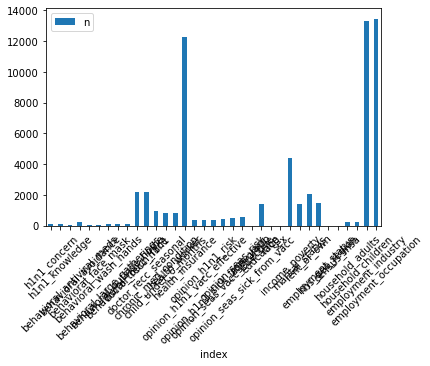

In [111]:
features_df.isna().sum().reset_index(name="n").plot.bar(x='index', y='n', rot=45)

In [71]:
# Replacing missing categorical variables with mode

In [112]:
train['race'].mode()

0    White
dtype: object

In [113]:
test['race'].mode()

0    White
dtype: object

In [114]:
train['sex'].mode()

0    Female
dtype: object

In [115]:
test['sex'].mode()

0    Female
dtype: object

In [116]:
train['marital_status'].mode()

0    Married
dtype: object

In [117]:
test['marital_status'].mode()

0    Married
dtype: object

In [118]:
train['rent_or_own'].mode()

0    Own
dtype: object

In [119]:
test['rent_or_own'].mode()

0    Own
dtype: object

In [120]:
train['hhs_geo_region'].mode()

0    lzgpxyit
dtype: object

In [122]:
test['hhs_geo_region'].mode()

0    lzgpxyit
dtype: object

In [123]:
train['census_msa'].mode()

0    MSA, Not Principle  City
dtype: object

In [124]:
test['census_msa'].mode()

0    MSA, Not Principle  City
dtype: object

In [125]:
train['employment_industry'].mode()

0    fcxhlnwr
dtype: object

In [126]:
test['employment_industry'].mode()

0    fcxhlnwr
dtype: object

In [127]:
train['employment_occupation'].mode()

0    xtkaffoo
dtype: object

In [128]:
test['employment_occupation'].mode()

0    xtkaffoo
dtype: object

In [ ]:
# We observe above that the most occuring values are the same for every categorical feature in both training and test data set
# Below, we are replacing NANs of all categorical variables with their respective modes.

In [147]:
for column in ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']:
    train[column].fillna(train[column].mode()[0], inplace=True)
    test[column].fillna(test[column].mode()[0], inplace=True)

In [146]:
train.isna().sum()

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                     0
r

In [148]:
test.isna().sum()

h1n1_concern                      85
h1n1_knowledge                   122
behavioral_antiviral_meds         79
behavioral_avoidance             213
behavioral_face_mask              19
behavioral_wash_hands             40
behavioral_large_gatherings       72
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            932
child_under_6_months             813
health_worker                    789
health_insurance               12228
opinion_h1n1_vacc_effective      398
opinion_h1n1_risk                380
opinion_h1n1_sick_from_vacc      375
opinion_seas_vacc_effective      452
opinion_seas_risk                499
opinion_seas_sick_from_vacc      521
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4497
marital_status                     0
r

In [ ]:
# Checking if there is high cardinality in the categorical features 

<AxesSubplot:>

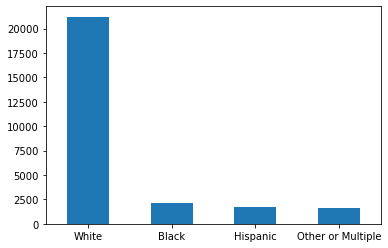

In [156]:
train['race'].value_counts().plot.bar(rot=0)

<AxesSubplot:>

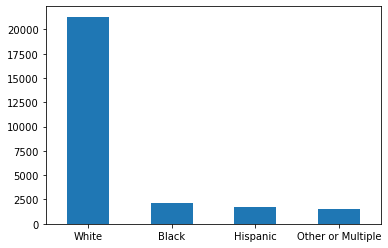

In [164]:
test['race'].value_counts().plot.bar(rot=0)

In [172]:
train['race'][train['race']!='White'] = 'Other'
test['race'][test['race']!='White'] = 'Other'

C:\Users\vanga\AppData\Local\Temp/ipykernel_51324/1639587409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['race'][train['race']!='White'] = 'Other'
C:\Users\vanga\AppData\Local\Temp/ipykernel_51324/1639587409.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['race'][test['race']!='White'] = 'Other'


<AxesSubplot:>

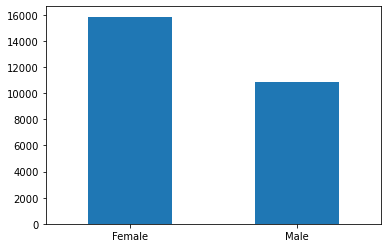

In [157]:
train['sex'].value_counts().plot.bar(rot=0)

<AxesSubplot:>

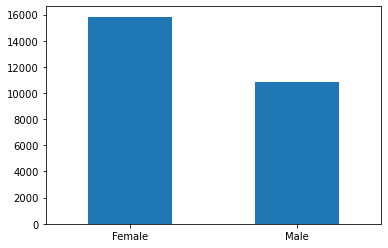

In [165]:
test['sex'].value_counts().plot.bar(rot=0)

<AxesSubplot:>

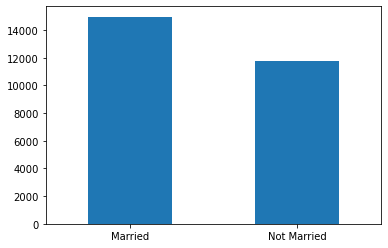

In [158]:
train['marital_status'].value_counts().plot.bar(rot=0)

<AxesSubplot:>

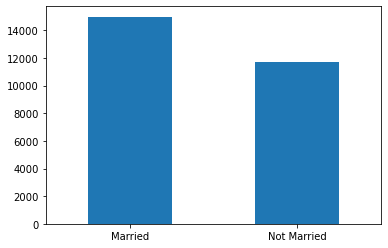

In [166]:
test['marital_status'].value_counts().plot.bar(rot=0)

<AxesSubplot:>

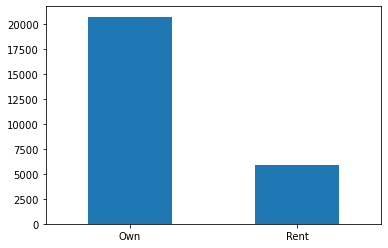

In [159]:
train['rent_or_own'].value_counts().plot.bar(rot=0)

<AxesSubplot:>

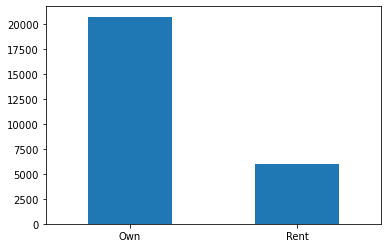

In [167]:
test['rent_or_own'].value_counts().plot.bar(rot=0)

<AxesSubplot:>

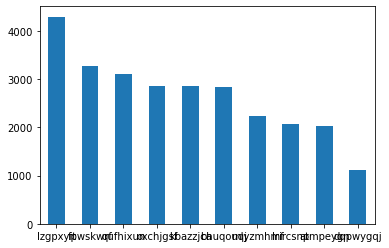

In [160]:
train['hhs_geo_region'].value_counts().plot.bar(rot=0)

<AxesSubplot:>

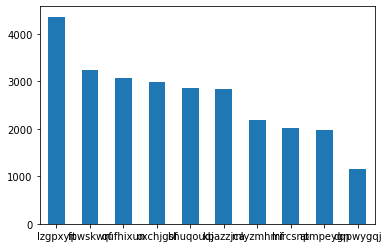

In [168]:
test['hhs_geo_region'].value_counts().plot.bar(rot=0)

<AxesSubplot:>

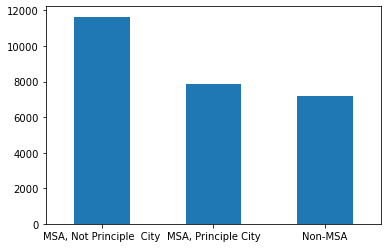

In [161]:
train['census_msa'].value_counts().plot.bar(rot=0)

<AxesSubplot:>

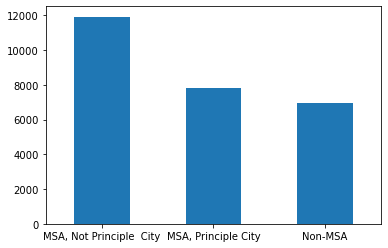

In [169]:
test['census_msa'].value_counts().plot.bar(rot=0)

<AxesSubplot:>

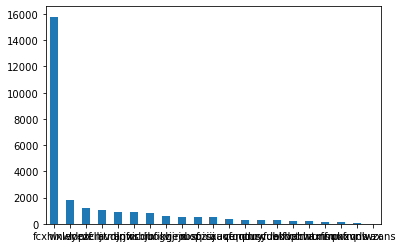

In [162]:
train['employment_industry'].value_counts().plot.bar(rot=0)

<AxesSubplot:>

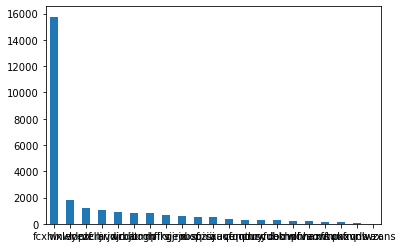

In [170]:
test['employment_industry'].value_counts().plot.bar(rot=0)

In [173]:
train['employment_industry'][train['employment_industry']!='fcxhlnwr'] = 'Other'
test['employment_industry'][test['employment_industry']!='fcxhlnwr'] = 'Other'

C:\Users\vanga\AppData\Local\Temp/ipykernel_51324/3192358993.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['employment_industry'][train['employment_industry']!='fcxhlnwr'] = 'Other'
C:\Users\vanga\AppData\Local\Temp/ipykernel_51324/3192358993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['employment_industry'][test['employment_industry']!='fcxhlnwr'] = 'Other'


<AxesSubplot:>

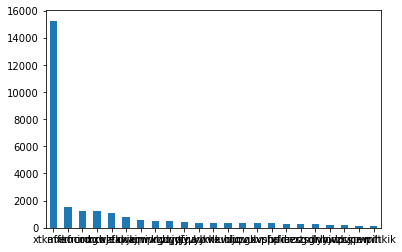

In [163]:
train['employment_occupation'].value_counts().plot.bar(rot=0)

<AxesSubplot:>

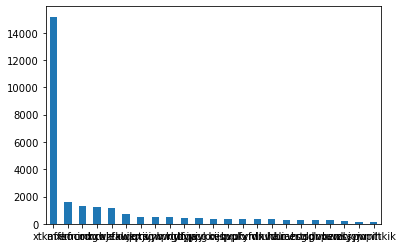

In [171]:
test['employment_occupation'].value_counts().plot.bar(rot=0)

In [175]:
train['employment_occupation'][train['employment_occupation']!='xtkaffoo'] = 'Other'
test['employment_occupation'][test['employment_occupation']!='xtkaffoo'] = 'Other'

C:\Users\vanga\AppData\Local\Temp/ipykernel_51324/3951103134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['employment_occupation'][train['employment_occupation']!='xtkaffoo'] = 'Other'
C:\Users\vanga\AppData\Local\Temp/ipykernel_51324/3951103134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['employment_occupation'][test['employment_occupation']!='xtkaffoo'] = 'Other'


## Working on Seasonal Vaccine model, which does not need class imbalance correction

In [ ]:
# Breaking training dataset into training and evaluation datasets before carrying any preprocessing/Feature Engineering/
# resampling to prevent data leakage

In [209]:
X_train, X_eval, y_train, y_eval = train_test_split(
    train,
    labels_seasonal_vaccine,
    test_size=0.20,
    shuffle=True,
    stratify=labels,
    random_state=RANDOM_SEED
)

In [ ]:
# Building LightGBM model

In [210]:
# LightGBM can handle categorical features by itself. We just need to make 
# sure the dataframe is using panda's built-in "category" data type.
cat_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']
X_train[cat_cols] = X_train[cat_cols].astype('category')
X_eval[cat_cols] = X_eval[cat_cols].astype('category')

In [218]:
params = {
      "cat_l2": 10,
      "cat_smooth": 10,
      "colsample_bytree": 0.8,
      "feature_fraction_bynode":  0.8,
      "learning_rate": 0.03,
      "max_depth": 6,
      "min_child_samples": 63,
      "min_data_per_group": 100,
      "n_estimators": 200,
      "num_leaves": 63,
      "path_smooth": 0,
      "reg_alpha":  0.05,
      "reg_lambda": 0.05,
      "subsample_freq": 1,
      "subsample": 0.8,
      "max_bin": 127,
      "extra_trees": False,
      "is_unbalance": True,
      "boosting_type": 'gbdt',
      "n_jobs": 1,
      "verbosity": -1,
      "seed": 77,
}

fit_params= {
    'feature_name': "auto",
    'categorical_feature': cat_cols,
}

start = time.time()
estimator = LGBMClassifier(**params)


# The more CV, the better our estimate of the score
inner_cv_scores = cross_validate(estimator, X_train, y_train, 
                                 fit_params=fit_params, 
                                 cv=15, 
                                 scoring="roc_auc", 
                                 n_jobs=5, 
                                 verbose=0, 
                                 return_train_score=True)
cv_scores=inner_cv_scores['test_score'].tolist()
duration = time.time() - start

print("CV Scores:")
print(["{:0.4f}".format(cv_score) for cv_score in cv_scores])
print("CV Score mean: {:.4f} ".format(np.mean(cv_scores)))
print("CV Score range: {:0.4f} -- {:0.4f}".format(np.mean(cv_scores) - np.std(cv_scores), np.mean(cv_scores) + np.std(cv_scores)))
print("Fit times: {}".format(duration))
print("Total duration: {}".format(duration))

CV Scores:
['0.8639', '0.8644', '0.8553', '0.8559', '0.8705', '0.8649', '0.8594', '0.8394', '0.8550', '0.8632', '0.8479', '0.8768', '0.8595', '0.8747', '0.8613']
CV Score mean: 0.8608 
CV Score range: 0.8515 -- 0.8701
Fit times: 3.721816062927246
Total duration: 3.721816062927246


In [220]:
final_model = LGBMClassifier(verbose=False,  cat_features=cat_cols, 
                          **params)

In [221]:
final_model.fit(X_train, y_train)

LGBMClassifier(cat_features=['race', 'sex', 'marital_status', 'rent_or_own',
                             'hhs_geo_region', 'census_msa',
                             'employment_industry', 'employment_occupation'],
               cat_l2=10, cat_smooth=10, colsample_bytree=0.8,
               extra_trees=False, feature_fraction_bynode=0.8,
               is_unbalance=True, learning_rate=0.03, max_bin=127, max_depth=6,
               min_child_samples=63, min_data_per_group=100, n_estimators=200,
               n_jobs=1, num_leaves=63, path_smooth=0, reg_alpha=0.05,
               reg_lambda=0.05, seed=77, subsample=0.8, subsample_freq=1,
               verbose=False, verbosity=-1)

In [240]:
predictions_se = final_model.predict_proba(X_eval)

In [229]:
predictions_se = predictions_se[:,1].reshape(-1,1)

In [224]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

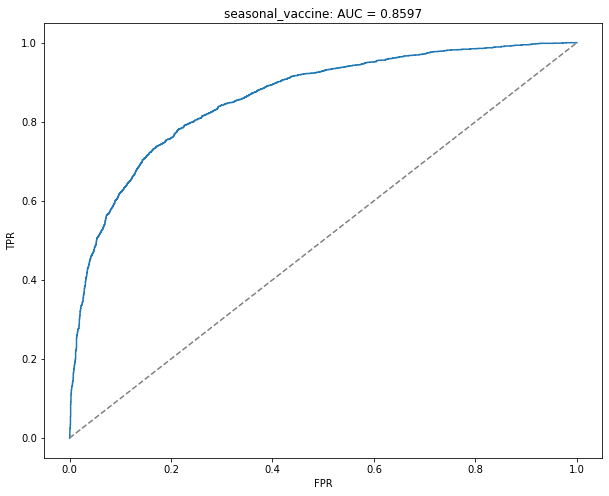

In [230]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_eval, 
    predictions_se, 
    'seasonal_vaccine',
    ax=ax
)

In [231]:
roc_auc_score(y_eval, predictions_se)

0.8597114784462268

In [254]:
# Of course, at this point, once you've found the best parameters etc., you would retrain the model on the full dataset:
cat_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']
train[cat_cols] = train[cat_cols].astype('category')
test[cat_cols] = test[cat_cols].astype('category')

final_model.fit(train, labels_seasonal_vaccine)
final_se = final_model.predict_proba(test)
final_se = final_se[:,1].reshape(-1,1)

[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] verbosity is set=-1, verbose=False will be ignored. Current value: verbosity=-1


LGBMClassifier(cat_features=['race', 'sex', 'marital_status', 'rent_or_own',
                             'hhs_geo_region', 'census_msa',
                             'employment_industry', 'employment_occupation'],
               cat_l2=10, cat_smooth=10, colsample_bytree=0.8,
               extra_trees=False, feature_fraction_bynode=0.8,
               is_unbalance=True, learning_rate=0.03, max_bin=127, max_depth=6,
               min_child_samples=63, min_data_per_group=100, n_estimators=200,
               n_jobs=1, num_leaves=63, path_smooth=0, reg_alpha=0.05,
               reg_lambda=0.05, seed=77, subsample=0.8, subsample_freq=1,
               verbose=False, verbosity=-1)

## Working on HIN1 Vaccine model, which needs class imbalance correction

In [ ]:
# Breaking training dataset into training and evaluation datasets before carrying any preprocessing/Feature Engineering/
# resampling to prevent data leakage

In [234]:
X_train, X_eval, y_train, y_eval = train_test_split(
    train,
    labels_h1n1_vaccine,
    test_size=0.20,
    shuffle=True,
    stratify=labels,
    random_state=RANDOM_SEED
)

In [ ]:
# Building LightGBM model

In [235]:
# LightGBM can handle categorical features by itself. We just need to make 
# sure the dataframe is using panda's built-in "category" data type.
cat_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']
X_train[cat_cols] = X_train[cat_cols].astype('category')
X_eval[cat_cols] = X_eval[cat_cols].astype('category')

In [236]:
params = {
      "cat_l2": 10,
      "cat_smooth": 10,
      "colsample_bytree": 0.8,
      "feature_fraction_bynode":  0.8,
      "learning_rate": 0.03,
      "max_depth": 6,
      "min_child_samples": 63,
      "min_data_per_group": 100,
      "n_estimators": 200,
      "num_leaves": 63,
      "path_smooth": 0,
      "reg_alpha":  0.05,
      "reg_lambda": 0.05,
      "subsample_freq": 1,
      "subsample": 0.8,
      "max_bin": 127,
      "extra_trees": False,
      "is_unbalance": True,
      "boosting_type": 'gbdt',
      "n_jobs": 1,
      "verbosity": -1,
      "seed": 77,
}

fit_params= {
    'feature_name': "auto",
    'categorical_feature': cat_cols,
}

start = time.time()
estimator = LGBMClassifier(**params)


# The more CV, the better our estimate of the score
inner_cv_scores = cross_validate(estimator, X_train, y_train, 
                                 fit_params=fit_params, 
                                 cv=15, 
                                 scoring="roc_auc", 
                                 n_jobs=5, 
                                 verbose=0, 
                                 return_train_score=True)
cv_scores=inner_cv_scores['test_score'].tolist()
duration = time.time() - start

print("CV Scores:")
print(["{:0.4f}".format(cv_score) for cv_score in cv_scores])
print("CV Score mean: {:.4f} ".format(np.mean(cv_scores)))
print("CV Score range: {:0.4f} -- {:0.4f}".format(np.mean(cv_scores) - np.std(cv_scores), np.mean(cv_scores) + np.std(cv_scores)))
print("Fit times: {}".format(duration))
print("Total duration: {}".format(duration))

CV Scores:
['0.8433', '0.8518', '0.8831', '0.8536', '0.8776', '0.8562', '0.8754', '0.8640', '0.8759', '0.8674', '0.8722', '0.8652', '0.8671', '0.8733', '0.8624']
CV Score mean: 0.8659 
CV Score range: 0.8553 -- 0.8765
Fit times: 11.15008544921875
Total duration: 11.15008544921875


In [246]:
final_model_h1n1 = LGBMClassifier(verbose=False, cat_features=cat_cols, 
                          **params)

In [247]:
final_model_h1n1.fit(X_train, y_train)

LGBMClassifier(cat_features=['race', 'sex', 'marital_status', 'rent_or_own',
                             'hhs_geo_region', 'census_msa',
                             'employment_industry', 'employment_occupation'],
               cat_l2=10, cat_smooth=10, colsample_bytree=0.8,
               extra_trees=False, feature_fraction_bynode=0.8,
               is_unbalance=True, learning_rate=0.03, max_bin=127, max_depth=6,
               min_child_samples=63, min_data_per_group=100, n_estimators=200,
               n_jobs=1, num_leaves=63, path_smooth=0, reg_alpha=0.05,
               reg_lambda=0.05, seed=77, subsample=0.8, subsample_freq=1,
               verbose=False, verbosity=-1)

In [249]:
predictions_h1n1 = final_model_h1n1.predict_proba(X_eval)

In [250]:
predictions_h1n1 = predictions_h1n1[:,1].reshape(-1,1)

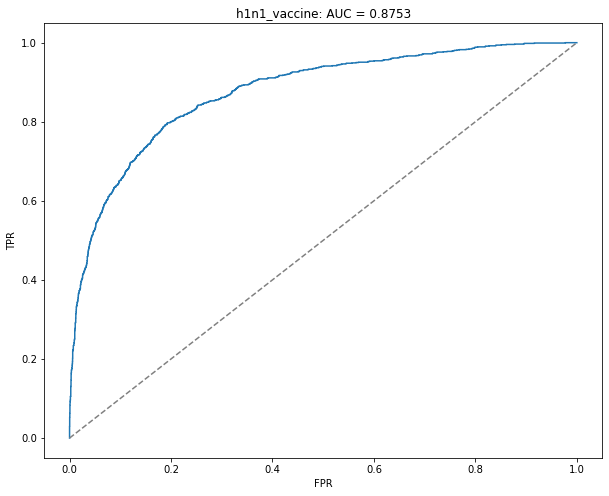

In [251]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_eval, 
    predictions_h1n1, 
    'h1n1_vaccine',
    ax=ax
)

In [252]:
roc_auc_score(y_eval, predictions_h1n1)

0.8753470458822039

In [262]:
# Of course, at this point, once you've found the best parameters etc., you would retrain the model on the full dataset:
cat_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']
train[cat_cols] = train[cat_cols].astype('category')
test[cat_cols] = test[cat_cols].astype('category')

final_model_h1n1.fit(train, labels_h1n1_vaccine)
final_h1n1 = final_model_h1n1.predict_proba(test)
final_h1n1 = final_h1n1[:,1].reshape(-1,1)

[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] verbosity is set=-1, verbose=False will be ignored. Current value: verbosity=-1


LGBMClassifier(cat_features=['race', 'sex', 'marital_status', 'rent_or_own',
                             'hhs_geo_region', 'census_msa',
                             'employment_industry', 'employment_occupation'],
               cat_l2=10, cat_smooth=10, colsample_bytree=0.8,
               extra_trees=False, feature_fraction_bynode=0.8,
               is_unbalance=True, learning_rate=0.03, max_bin=127, max_depth=6,
               min_child_samples=63, min_data_per_group=100, n_estimators=200,
               n_jobs=1, num_leaves=63, path_smooth=0, reg_alpha=0.05,
               reg_lambda=0.05, seed=77, subsample=0.8, subsample_freq=1,
               verbose=False, verbosity=-1)

# Make Submission

In [263]:
submission_df = pd.read_csv(
    DATA_PATH / "submission_format.csv", 
    index_col="respondent_id"
)

In [264]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = final_h1n1
submission_df["seasonal_vaccine"] = final_se

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.405917,0.246017
26708,0.150319,0.039015
26709,0.550466,0.738821
26710,0.879003,0.912211
26711,0.621055,0.560307


In [267]:
date = pd.Timestamp.now().strftime(format='%Y-%m-%d_%H-%M_')
filepath = Path('D:/MMA 869 Machine Learning & AI/Team Assignment/submission_format.csv') 
submission_df.to_csv(filepath, index=True)

# Building a Pipeline

In [59]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols)
    ],
    remainder = "drop"
)

In [ ]:
pipe1 = make_pipeline (StandardScaler(),SimpleImputer(strategy='median') )